In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.feature_extraction.text import TfidfVectorizer
import kagglehub
import joblib
from tqdm import tqdm
from  sklearn.preprocessing import LabelEncoder
from sklearn.metrics import roc_curve, auc, f1_score, accuracy_score, precision_score, recall_score, confusion_matrix, classification_report
from sklearn.model_selection import train_test_split, cross_validate, train_test_split
from wordcloud import WordCloud, STOPWORDS
import re
from nltk.stem import WordNetLemmatizer
from nltk.corpus import wordnet
import nltk
nltk.download('wordnet')
import swifter
from sklearn.linear_model import SGDClassifier, LogisticRegression
from scipy.sparse import vstack
from sklearn.naive_bayes import BernoulliNB

from sklearn.svm import LinearSVC
import string
import seaborn as sns
from sklearn.ensemble import RandomForestClassifier, GradientBoostingRegressor
from sklearn.tree import DecisionTreeClassifier
from xgboost import XGBClassifier

import contractions

import demoji
demoji.download_codes()


[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\dell\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


In [2]:
text = '''I'll be theeeeeeeeeeeeeeeere within 5 min. Shouldn't you be there too?
          I'd love to see u there my dear. It's awesome to meet new friends.
          We've been waiting for this day for so long.'''

# creating an empty list
expanded_words = []
for word in text.split():
  # using contractions.fix to expand the shortened words
  expanded_words.append(contractions.fix(word))

expanded_text = ' '.join(expanded_words)
print('Original text: ' + text)
print('Expanded_text: ' + expanded_text)

Original text: I'll be theeeeeeeeeeeeeeeere within 5 min. Shouldn't you be there too?
          I'd love to see u there my dear. It's awesome to meet new friends.
          We've been waiting for this day for so long.
Expanded_text: I will be theeeeeeeeeeeeeeeere within 5 min. Should not you be there too? I would love to see you there my dear. It is awesome to meet new friends. We have been waiting for this day for so long.


In [3]:
# Download data from kaggle: https://www.kaggle.com/datasets/kazanova/sentiment140/data
# path = kagglehub.dataset_download("kazanova/sentiment140")

# print("Path to dataset files:", path)

<!-- <p style="color: lightblue;">Sentiment labeling in the dataset:</p>
<ul>
  <li>0 = negative</li>
  <li>2 = neutral</li>
  <li>4 = positive</li>
</ul> -->
Sentiment labeling in the dataset:
- 0 = negative
- 4 = positive

In [4]:
df = pd.read_csv('train.csv', header=None, names=["sentiment", "ids", "date", "flag", "user", "text"])
df.head()

,sentiment,ids,date,flag,user,text
0,0,1467810369,Mon Apr 06 22:19:45 PDT 2009,NO_QUERY,_TheSpecialOne_,"@switchfoot http://twitpic.com/2y1zl - Awww, t..."
1,0,1467810672,Mon Apr 06 22:19:49 PDT 2009,NO_QUERY,scotthamilton,is upset that he can't update his Facebook by ...
2,0,1467810917,Mon Apr 06 22:19:53 PDT 2009,NO_QUERY,mattycus,@Kenichan I dived many times for the ball. Man...
3,0,1467811184,Mon Apr 06 22:19:57 PDT 2009,NO_QUERY,ElleCTF,my whole body feels itchy and like its on fire
4,0,1467811193,Mon Apr 06 22:19:57 PDT 2009,NO_QUERY,Karoli,"@nationwideclass no, it's not behaving at all...."


In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1600000 entries, 0 to 1599999
Data columns (total 6 columns):
 #   Column     Non-Null Count    Dtype 
---  ------     --------------    ----- 
 0   sentiment  1600000 non-null  int64 
 1   ids        1600000 non-null  int64 
 2   date       1600000 non-null  object
 3   flag       1600000 non-null  object
 4   user       1600000 non-null  object
 5   text       1600000 non-null  object
dtypes: int64(2), object(4)
memory usage: 73.2+ MB


In [6]:
df.isna().sum()

sentiment    0
ids          0
date         0
flag         0
user         0
text         0
dtype: int64

We then create another dataframe where it only have the columns we will be using :

In [7]:
df_cleaned = df[['sentiment', 'text']]
df_cleaned.head()

,sentiment,text
0,0,"@switchfoot http://twitpic.com/2y1zl - Awww, t..."
1,0,is upset that he can't update his Facebook by ...
2,0,@Kenichan I dived many times for the ball. Man...
3,0,my whole body feels itchy and like its on fire
4,0,"@nationwideclass no, it's not behaving at all...."


We will map the labels (0 = negative, 1 = positive)

In [8]:
df_cleaned.sentiment = LabelEncoder().fit_transform(df_cleaned.sentiment)
df_cleaned

C:\Users\dell\AppData\Local\Temp\ipykernel_11604\3272369782.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_cleaned.sentiment = LabelEncoder().fit_transform(df_cleaned.sentiment)


,sentiment,text
0,0,"@switchfoot http://twitpic.com/2y1zl - Awww, t..."
1,0,is upset that he can't update his Facebook by ...
2,0,@Kenichan I dived many times for the ball. Man...
3,0,my whole body feels itchy and like its on fire
4,0,"@nationwideclass no, it's not behaving at all...."
...,...,...
1599995,1,Just woke up. Having no school is the best fee...
1599996,1,TheWDB.com - Very cool to hear old Walt interv...
1599997,1,Are you ready for your MoJo Makeover? Ask me f...
1599998,1,Happy 38th Birthday to my boo of alll time!!! ...


### Let's check the distribution of sentiments:

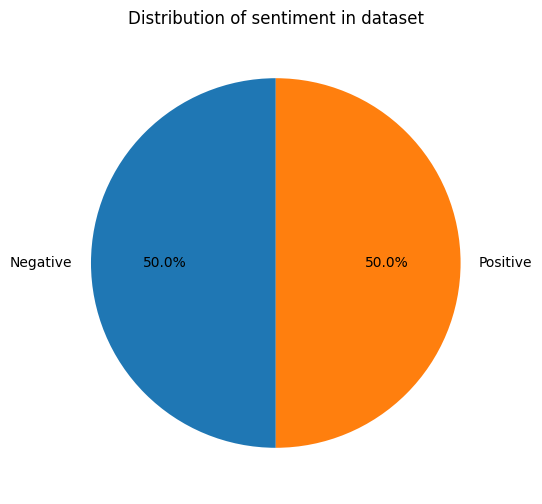

In [9]:

# Pie chart
# Count sentiment values, ensuring no NaNs or invalid entries
sentiment_counts = df_cleaned['sentiment'].value_counts()
labels = sentiment_counts.index.map({0: 'Negative', 1: 'Positive'})

# Pie chart
plt.figure(figsize=(10, 6))
plt.pie(
    sentiment_counts.values,
    labels=labels,
    autopct='%1.1f%%',
    startangle=90
)
plt.title('Distribution of sentiment in dataset')
plt.show()

As we can see there is a balance between positive and negative sentiment.

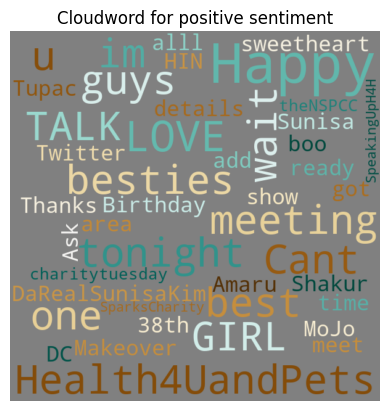

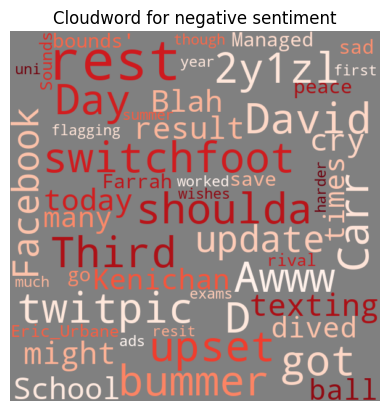

In [10]:
from wordcloud import STOPWORDS
text_positive = str(df_cleaned[df_cleaned['sentiment'] == 1]['text'].values)
text_negative = str(df_cleaned[df_cleaned['sentiment'] == 0]['text'].values)

def plot_word_cloud(text,desc,color) :


    wc = WordCloud(width=600,height=600,background_color="gray", max_words=200, stopwords=STOPWORDS,colormap=color,  max_font_size=90,collocations = False, random_state=42)

    wc.generate(text)
    plt.imshow(wc,interpolation="bilinear")
    plt.axis("off")
    plt.title(f"Cloudword for {desc}")
    plt.show()


plot_word_cloud(text_positive, "positive sentiment", "BrBG")
plot_word_cloud(text_negative, "negative sentiment", "Reds")

# Preprocessing

In [24]:
class TextPreprocessor:
    def __init__(self):
        # Initialize the word lemmatizer and the emojis dictionary
        self.word_lemmatizer = WordNetLemmatizer()
        self.emojis = {
            ':)': 'smile',
             ':-)': 'smile',
             ';d': 'wink',
             ':-E': 'vampire',
             ':(': 'sad',

            ':-(': 'sad',
             ':-<': 'sad',
             ':P': 'raspberry',
             ':O': 'surprised',

            ':-@': 'shocked',
             ':@': 'shocked',
            ':-$': 'confused',
             ':\\': 'annoyed',

            ':#': 'mute',
             ':X': 'mute',
             ':^)': 'smile',
             ':-&': 'confused',
             '$_$': 'greedy',

            '@@': 'eyeroll',
             ':-!': 'confused',
             ':-D': 'smile',
             ':-0': 'yell',
             'O.o': 'confused',

            '<(-_-)>': 'robot',
             'd[-_-]b': 'dj',
             ":'-)": 'sadsmile',
             ';)': 'wink',
             ';D': 'wink',

            ';-)': 'wink',
             'O:-)': 'angel',
            'O*-)': 'angel',
            '(:-D': 'gossip',
             '=^.^=': 'cat',
             ':D':'smile',
            ':\\': 'annoyed',
        }

    def clean_text(self, text):
        """Cleaning text from unwanted elements"""
        text = text.lower().strip()
        text = contractions.fix(text)
        # Remove URLs
        text = re.sub(r'https?://(?:[-\w.]|(?:%[\da-fA-F]{2}))+', '', text)
        # Remove @username
        text = re.sub(r'@\w+', '', text).strip()
        # Remove email addresses
        text = re.sub(r'[\w\.\-\+]+@([\w\-]+\.)+[\w\-]{2,4}', '', text)
        # Remove quoted text
        text = re.sub(r'["\'].*?["\']', '', text)
        # Remove hashtags
        text = re.sub(r'#(\w+)', r'\1', text)
        # Remove "etc."
        text = re.sub(r'\betc\.?\b', '', text, flags=re.IGNORECASE)
        return text

    def filter_non_english_words(self, text):
        """
        Remove all words that contain non-English characters.
        """
        pattern = r'\b(?:[a-zA-Z]+|EMOJI_[a-zA-Z_]+)\b'
        filtered = re.findall(pattern, text)
        return ' '.join(filtered)

    def reduce_len_text(self, text):
        """Reduce text repetitive letters """
        repeat_regexp = re.compile(r'(.)\1{2,}')
        return repeat_regexp.sub(r'\1', text)
    def lemmatize_text(self, text):
        return ' '.join(self.word_lemmatizer.lemmatize(word) for word in text.split())

    def handle_emojies(self, text):
        """Replace emojis with text"""
        for emoji, meaning in self.emojis.items():
            text = text.replace(emoji, meaning)
            text = demoji.replace_with_desc(text)
        return text

    def preprocess(self, text):
        """
        Preprocess using all the previous functions
        """
        # features = self.extract_features(text)

        replace_emojie = self.handle_emojies(text)
        cleaned_text = self.clean_text(replace_emojie)
        no_repetition = self.reduce_len_text(cleaned_text)
        lemmatized_text = self.lemmatize_text(no_repetition)
        clean = self.filter_non_english_words(lemmatized_text)
        # clean = self.filter_non_english_words(lemmatized_text)
        return clean

pre = TextPreprocessor()
word = "#cool #awesooome #funny #lolllllll jojojojooooooooj eample@gmail.com #haha #hilariouuuusss #funnnnnnnnnn  i'll be there don't miss it  :() "
pre.preprocess(word)


'cool awesome funny lol jojojojoj eample com haha hilarious fun i will be there do not miss it sad'

In [ ]:
import swifter
pre = TextPreprocessor()
df_cleaned['cleaned_text'] = tqdm(df_cleaned['text'].swifter.apply(pre.preprocess), desc='prerpocessing')

df_cleaned.head()

Pandas Apply:   0%|          | 0/1600000 [00:00<?, ?it/s]

KeyboardInterrupt: 

# TF-IDF

In [54]:
tfidf = TfidfVectorizer(stop_words='english',ngram_range=(1, 2), max_features=10000)
tfidf.fit(df_cleaned.cleaned_text)


TfidfVectorizer(max_features=10000, ngram_range=(1, 2), stop_words='english')

In [55]:

# Liste pour stocker les matrices TF-IDF par lots
sparse_matrices = []

for i in tqdm(range(0, len(df_cleaned), 10000), desc='Batch processing'):
    batch = df_cleaned.cleaned_text[i:i + 10000]
    tfidf_matrix_batch = tfidf.transform(batch)

    # Ajouter la matrice sparse au tableau
    sparse_matrices.append(tfidf_matrix_batch)

# Concaténer toutes les matrices sparse en une seule
final_sparse_matrix = vstack(sparse_matrices)


Batch processing:   0%|          | 0/160 [00:00<?, ?it/s]

Batch processing: 100%|██████████| 160/160 [03:38<00:00,  1.37s/it]


In [56]:
# Créer le DataFrame avec la matrice sparse
df_matrix = pd.DataFrame.sparse.from_spmatrix(final_sparse_matrix, columns=tfidf.get_feature_names_out())
df_matrix['label'] = df_cleaned['sentiment']

In [71]:
df_matrix['label'].isna().sum()

0

We will calculate the tfidf score mean, we will use it later to only get words with higher score

In [57]:

tfidf_scores = []
batch_size = 10000

tfidf_matrix_sparse = tfidf.transform(df_cleaned['cleaned_text'])

for start in tqdm(range(0, tfidf_matrix_sparse.shape[0], batch_size)):
    end = min(start + batch_size, tfidf_matrix_sparse.shape[0])
    batch = tfidf_matrix_sparse[start:end]

    # Calculez la moyenne des scores TF-IDF pour chaque document dans le batch
    batch_scores = batch.mean(axis=1).A1  # .A1 convertit en tableau numpy 1D
    tfidf_scores.extend(batch_scores)


df_cleaned['tfidf_score'] = tfidf_scores



100%|██████████| 160/160 [00:01<00:00, 82.66it/s]


In [58]:
df_cleaned

,sentiment,text,cleaned_text,links,emails,quotes,hashtags,etc_count,nb_caracter,tfidf_score
0,0,"@switchfoot http://twitpic.com/2y1zl - Awww, t...",Aw that s bumer You shoulda got David Car of T...,1,0,0,0,0,115,0.000273
1,0,is upset that he can't update his Facebook by ...,is upset that he can t update his Facebok by t...,0,0,0,0,0,111,0.000294
2,0,@Kenichan I dived many times for the ball. Man...,dived many time for the bal Managed to save Th...,0,0,0,0,0,89,0.000240
3,0,my whole body feels itchy and like its on fire,my whole body fel itchy and like it on fire,0,0,0,0,0,47,0.000190
4,0,"@nationwideclass no, it's not behaving at all....",no itm mad why am here because can t se you al...,0,0,1,0,0,111,0.000216
...,...,...,...,...,...,...,...,...,...,...
1599995,1,Just woke up. Having no school is the best fee...,Just woke up Having no schol is the best felin...,0,0,0,0,0,56,0.000260
1599996,1,TheWDB.com - Very cool to hear old Walt interv...,TheWDB com Very col to hear old Walt interviews,1,0,0,0,0,76,0.000200
1599997,1,Are you ready for your MoJo Makeover? Ask me f...,Are you ready for your MoJo Makeover Ask me fo...,0,0,0,0,0,57,0.000141
1599998,1,Happy 38th Birthday to my boo of alll time!!! ...,Hapy Birthday to my bo of al time Tupac Amaru ...,0,0,0,0,0,65,0.000259


The dataset have +1.6m tweets... So we Will have to reduce it to 500 000, based on tf-idf scores and categories


In [59]:
# simples
df_positive_sample = df_cleaned[df_cleaned['sentiment'] == 1].sort_values(by="tfidf_score", ascending= False).head(250000)
df_negative_sample = df_cleaned[df_cleaned['sentiment'] == 0].sort_values(by="tfidf_score", ascending= False).head(250000)

# Combine simples
df_reduced = pd.concat([df_positive_sample, df_negative_sample])
print(f"Reduced dataset size: {len(df_reduced)}")

Reduced dataset size: 500000


In [60]:
df_reduced

,sentiment,text,cleaned_text,links,emails,quotes,hashtags,etc_count,nb_caracter,tfidf_score
914250,1,Well friends we just got in and it has been a ...,Wel friend we just got in and it ha ben long d...,0,0,0,0,0,129,0.000510
1329876,1,It was quite disturbing.But a real band bondin...,It wa quite disturbing But real band bonding m...,0,0,0,0,0,137,0.000501
966186,1,"josh just left for work, going to see mom and ...",josh just left for work going to se mom and da...,0,0,0,0,0,135,0.000500
842216,1,"party last night.. lots of fun, 5am sleep time...",party last night lot of fun slep time glad to ...,0,0,0,0,0,134,0.000500
1275067,1,"Morning all still wanna go back to sleep, got...",Morning al stil wana go back to slep got engli...,0,0,0,0,0,109,0.000498
...,...,...,...,...,...,...,...,...,...,...
449118,0,@FrankieTheSats awwww &lt;3 i'm sure dougie's ...,aw lt is mising you he l be home son though ri...,0,0,1,0,0,96,0.000273
47719,0,Another butt-crack of dawn start. I really nee...,Another but crack of dawn start realy ned some...,0,0,0,0,0,60,0.000273
14333,0,Printing forms to apply for Dan's Visa... and ...,Printing form to aply for Dan s Visa and just ...,0,0,0,0,0,104,0.000273
617369,0,"poor rob Glad he's fine, but i'm sure it was...",por rob Glad hem sure it wa scarey startling t...,0,0,1,0,0,90,0.000273


## TF-IDF for the reduced df: df_reduced

In [229]:
tfidf_reduced = TfidfVectorizer(stop_words='english', ngram_range=(1, 2), max_features=10000)
matrix_reduced = tfidf_reduced.fit_transform(df_reduced.cleaned_text)


In [230]:
from scipy.sparse import csr_matrix

# Créer une DataFrame sparse
df_matrix_reduced = pd.DataFrame.sparse.from_spmatrix(matrix_reduced, columns=tfidf_reduced.get_feature_names_out())

# Ajouter la colonne des labels
df_matrix_reduced['label'] = df_reduced['sentiment'].values


In [231]:
df_matrix_reduced

,aah,aaron,ab,abandoned,abc,ability,abit,able,able make,able se,...,zac,zach,zealand,zero,zo,zoe,zombie,zomg,zone,zz
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
499995,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
499996,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
499997,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
499998,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [232]:
df_matrix_reduced.columns

Index(['aah', 'aaron', 'ab', 'abandoned', 'abc', 'ability', 'abit', 'able',
       'able make', 'able se',
       ...
       'zac', 'zach', 'zealand', 'zero', 'zo', 'zoe', 'zombie', 'zomg', 'zone',
       'zz'],
      dtype='object', length=10000)

## Testing models

In [233]:
# Features
X = matrix_reduced

# Labels
y = df_matrix_reduced['label']

# Diviser les données en ensembles d'entraînement et de test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

print("Shape of X_train:", X_train.shape)
print("Shape of X_test:", X_test.shape)
print("Shape of y_train:", y_train.shape)
print("Shape of y_test:", y_test.shape)


Shape of X_train: (400000, 10000)
Shape of X_test: (100000, 10000)
Shape of y_train: (400000,)
Shape of y_test: (100000,)


In [234]:
def test_model(model_name):
    model = model_name
    model.fit(X_train, y_train)

    y_pred = model.predict(X_test)
    mse = mean_squared_error(y_test, y_pred)
    f1 = f1_score(y_test, y_pred, average='weighted')
    accuracy = accuracy_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred, average='weighted')
    recall = recall_score(y_test, y_pred, average='weighted')
    # roc_auc = roc_auc_score(y_test, model.predict_proba(X_test), multi_class='ovr')

    print(f"F1 Score: {f1}")
    print(f"Mean Squared Error: {mse}")
    print(f"Accuracy: {accuracy}")
    print(f"Precision: {precision}")
    print(f"Recall: {recall}")
    print("\nClassification Report:\n", classification_report(y_test, y_pred))

    if hasattr(model_name, "predict_proba"):
        y_probs = model.predict_proba(X_test)[:, 1]

        fpr, tpr, thresholds = roc_curve(y_test, y_probs)
        roc_auc = auc(fpr, tpr)

        plt.figure()
        plt.plot(fpr, tpr, color='darkorange', lw=2, label=f"ROC Curve (AUC = {roc_auc:.2f})")
        plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
        plt.xlabel("False Positive Rate")
        plt.ylabel("True Positive Rate")
        plt.title("Receiver Operating Characteristic (ROC) Curve")
        plt.legend(loc="lower right")
        plt.show()

    conf_matrix = confusion_matrix(y_test, y_pred)
    sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues')
    plt.xlabel("Predicted")
    plt.ylabel("True")
    plt.title("Confusion Matrix")
    plt.show()
    return model


Trying with the following models:
<!-- - Naive Bayes Classifier -->
<!-- - Support Vector Machine (SVM) -->
- SGDClassifier
- SVC
- BernoulliNB
- XGBOOST
- Logistic Regression
- Random Forest
<!-- - Gradient Boosting Machines (GBM) -->

### SGDClassifier

F1 Score: 0.7592510658430902
Mean Squared Error: 0.24066
Accuracy: 0.75934
Precision: 0.7597261183616568
Recall: 0.75934

Classification Report:
               precision    recall  f1-score   support

           0       0.77      0.74      0.75     50004
           1       0.75      0.78      0.76     49996

    accuracy                           0.76    100000
   macro avg       0.76      0.76      0.76    100000
weighted avg       0.76      0.76      0.76    100000



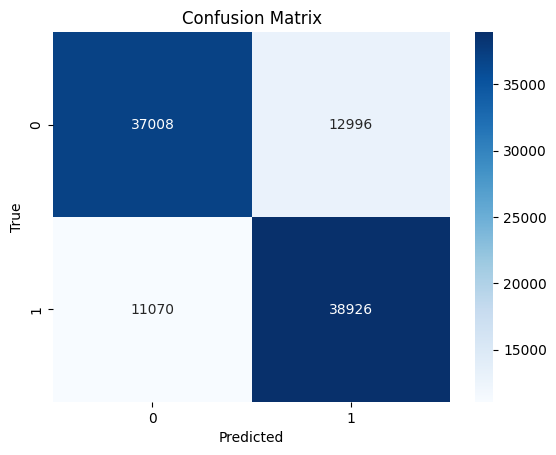

In [223]:
SGDclassifier = test_model(SGDClassifier())

### Logistique Regression

F1 Score: 0.7714516722793328
Mean Squared Error: 0.22851
Accuracy: 0.77149
Precision: 0.771673843258076
Recall: 0.77149

Classification Report:
               precision    recall  f1-score   support

           0       0.78      0.76      0.77     50004
           1       0.76      0.78      0.77     49996

    accuracy                           0.77    100000
   macro avg       0.77      0.77      0.77    100000
weighted avg       0.77      0.77      0.77    100000



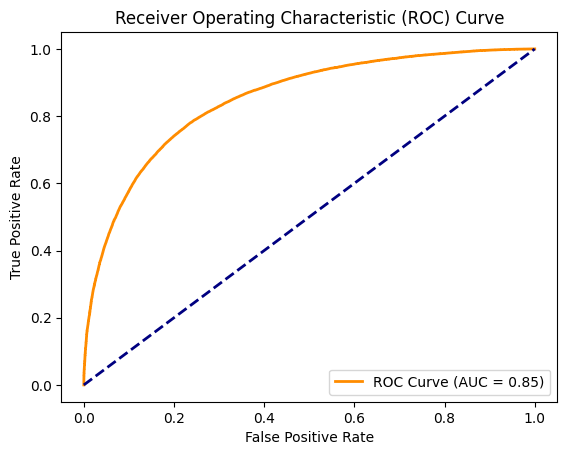

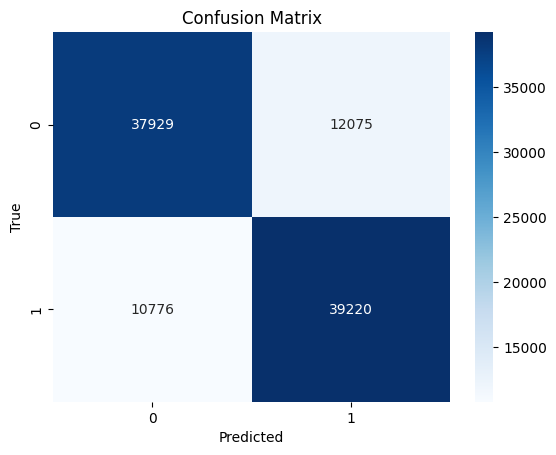

In [235]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report

LR = test_model(LogisticRegression(max_iter=1000))


### Random Forest Classifier

F1 Score: 0.752237916716809
Mean Squared Error: 0.24776
Accuracy: 0.75224
Precision: 0.7522481397880626
Recall: 0.75224

Classification Report:
               precision    recall  f1-score   support

           0       0.75      0.76      0.75     50004
           1       0.75      0.75      0.75     49996

    accuracy                           0.75    100000
   macro avg       0.75      0.75      0.75    100000
weighted avg       0.75      0.75      0.75    100000



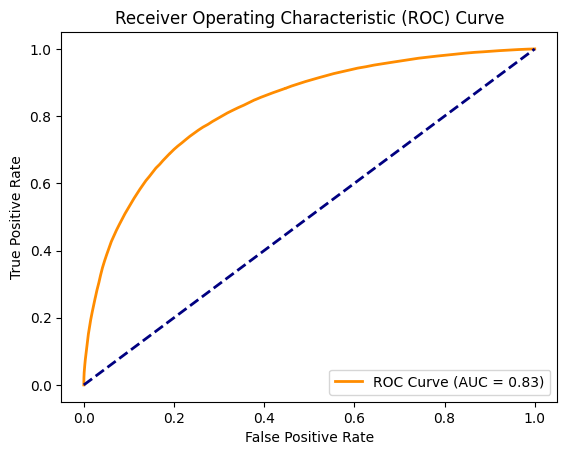

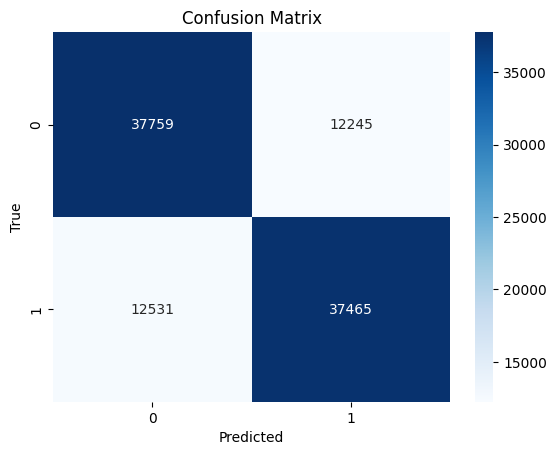

RandomForestClassifier(n_jobs=-1)

In [212]:
test_model(RandomForestClassifier(n_jobs=-1))
# it take too much time (1h20min) and not the most ideal for big dataset

### LinearSVC

F1 Score: 0.7697715765497792
Mean Squared Error: 0.23017
Accuracy: 0.76983
Precision: 0.7701061391722899
Recall: 0.76983

Classification Report:
               precision    recall  f1-score   support

           0       0.78      0.75      0.77     50004
           1       0.76      0.79      0.77     49996

    accuracy                           0.77    100000
   macro avg       0.77      0.77      0.77    100000
weighted avg       0.77      0.77      0.77    100000



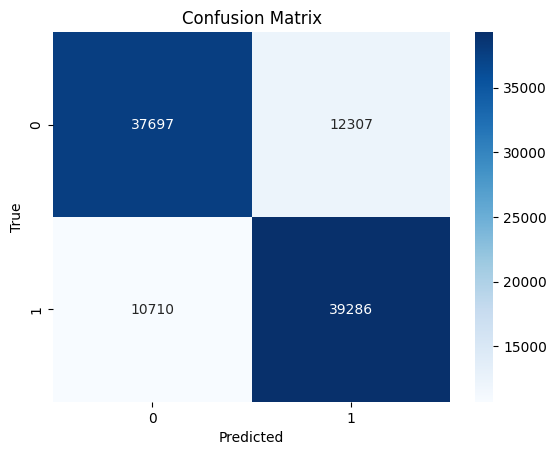

In [225]:
svc = test_model(LinearSVC())

### BernoulliNB

F1 Score: 0.7530085000406892
Mean Squared Error: 0.24697
Accuracy: 0.75303
Precision: 0.7531170133071347
Recall: 0.75303

Classification Report:
               precision    recall  f1-score   support

           0       0.75      0.76      0.76     50004
           1       0.76      0.74      0.75     49996

    accuracy                           0.75    100000
   macro avg       0.75      0.75      0.75    100000
weighted avg       0.75      0.75      0.75    100000



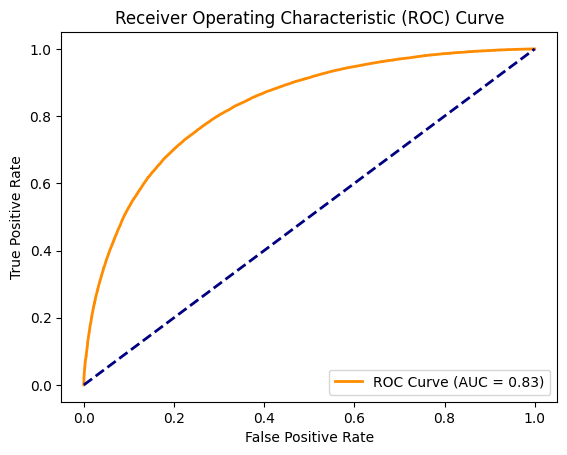

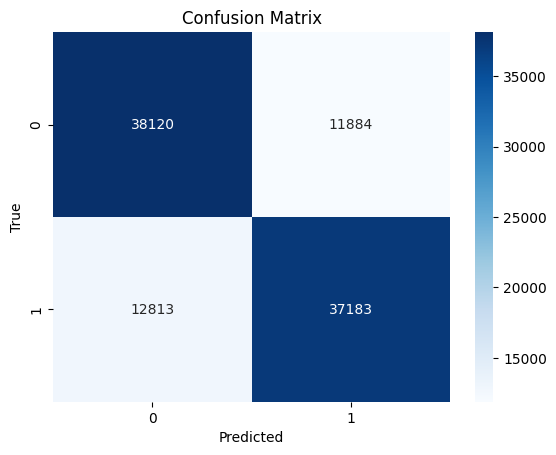

In [218]:
bern = test_model(BernoulliNB(alpha = 2))

### XGBoost Classifier

In [128]:
from sklearn.decomposition import PCA

pca = PCA(n_components=100)
X_train_pca = pca.fit_transform(X_train)
X_test_pca = pca.transform(X_test)



model = XGBClassifier(tree_method='gpu_hist', predictor='gpu_predictor')
model.fit(X_train_pca, y_train)
y_pred = model.predict(X_test_pca)
mse = mean_squared_error(y_test, y_pred)
f1 = f1_score(y_test, y_pred, average='weighted')
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred, average='weighted')
recall = recall_score(y_test, y_pred, average='weighted')
print(f"F1 Score: {f1}")
print(f"Mean Squared Error: {mse}")
print(f"Accuracy: {accuracy}")
print(f"Precision: {precision}")
print(f"Recall: {recall}")

# test_model(XGBClassifier(tree_method='gpu-hist', predictor="gpu_predictor"))

c:\Users\dell\anaconda3\envs\Myenv\Lib\site-packages\xgboost\core.py:160: UserWarning: [01:13:54] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0b3782d1791676daf-1\xgboost\xgboost-ci-windows\src\common\error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)
c:\Users\dell\anaconda3\envs\Myenv\Lib\site-packages\xgboost\core.py:160: UserWarning: [01:13:54] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0b3782d1791676daf-1\xgboost\xgboost-ci-windows\src\learner.cc:742: 
Parameters: { "predictor" } are not used.

  warnings.warn(smsg, UserWarning)
c:\Users\dell\anaconda3\envs\Myenv\Lib\site-packages\xgboost\core.py:160: UserWarning: [01:14:20] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0b3782d1791676daf-1\xgboost\xgboost-ci-windows\src\

F1 Score: 0.7055684564429108
Mean Squared Error: 0.29443
Accuracy: 0.70557
Precision: 0.7055745739353407
Recall: 0.70557


Best one so fars was Logistique regression with  an accuracy of 77%

Quick test of the model

In [242]:
# Nouveaux textes
new_texts = ["I love this product, it is amazing!", "I hate this experience, never again.", "Damn! i love it ", "The sky is blue"]

# Prétraitement
preprocessed_texts = [pre.preprocess(text)[0] for text in new_texts]  # Assurez-vous d'utiliser votre fonction de prétraitement

# Transformation en TF-IDF (utiliser le même tfidf_reduced que pendant l'entraînement)
new_texts_tfidf = tfidf_reduced.transform(preprocessed_texts)

# Prédictions
new_predictions = LR.predict(new_texts_tfidf)

# Mapping des labels pour affichage
label_map = {0: "Negative", 1: "Positive"}  # Adaptez selon vos classes
translated_predictions = [label_map[pred] for pred in new_predictions]

print("Human-readable Predictions:", translated_predictions)


Human-readable Predictions: ['Positive', 'Negative', 'Positive', 'Positive']


<!-- Changes to make the model predict better -->

<!-- 0.7714516722793328 -->


In [241]:
joblib.dump(tfidf_reduced, "TF-IDF Vector.pkl")
joblib.dump(LR, "LR sentiment analysis.joblib")

['LR sentiment analysis.joblib']